# Problem set 7: Solving the consumer problem with income risk

In [5]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Tasks

Solving the consumer problem is the **primary task** in this exercise set. You should spend most of the time you have on testing that you understand the different optimizers (problem I) and on solving the intertemporal consumption model (problem III). If for instance you are stuck in plotting, then skip ahead.   

## Optimization problem I

Consider the function

$$ 
f(\boldsymbol{x}) = f(x_1,x_2) = (x_1^2 - x_1x_2 + x_2^2)^2
$$

Define it in **sympy** by:

In [7]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (x1**2 - x1*x2 + x2**2)**2

The **Jacobian** is

In [8]:
f1 = sm.diff(f,x1)
f2 = sm.diff(f,x2)
sm.Matrix([f1,f2])

Matrix([
[ (4*x_1 - 2*x_2)*(x_1**2 - x_1*x_2 + x_2**2)],
[(-2*x_1 + 4*x_2)*(x_1**2 - x_1*x_2 + x_2**2)]])

The **Hessian**  is

In [9]:
f11 = sm.diff(f,x1,x1)
f12 = sm.diff(f,x1,x2)
f21 = sm.diff(f,x2,x1)
f22 = sm.diff(f,x2,x2)
sm.Matrix([[f11,f12],[f21,f22]])

Matrix([
[      2*(2*x_1**2 - 2*x_1*x_2 + 2*x_2**2 + (2*x_1 - x_2)**2), 2*(-x_1**2 + x_1*x_2 - x_2**2 - (x_1 - 2*x_2)*(2*x_1 - x_2))],
[2*(-x_1**2 + x_1*x_2 - x_2**2 - (x_1 - 2*x_2)*(2*x_1 - x_2)),       2*(2*x_1**2 - 2*x_1*x_2 + 2*x_2**2 + (x_1 - 2*x_2)**2)]])

**Question A:** Lambdify $f(x_1,x_2)$ and use it to create: 

$(i)$ a 3D surfaceplot looking like this:

<img src="surfaceplot.png" 
     width="400" 
     height="500" />

$(ii)$ a contourplot looking like: 

<img src="contourplot.png" 
     width="400" 
     height="500" />

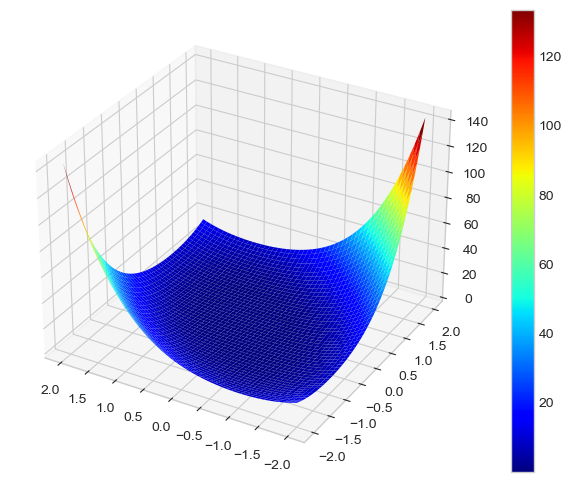

In [10]:
_f = sm.lambdify((x1,x2),f)

# 3D plot
x1_vec = np.linspace(-2, 2, 500)
x2_vec = np.linspace(-2, 2, 500)
x1_grid, x2_grid = np.meshgrid(x1_vec, x2_vec, indexing = "ij")
f_grid = _f(x1_grid, x2_grid)

# Initialize figure
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1,1,1, projection="3d")
cs = ax.plot_surface(x1_grid, x2_grid, f_grid, cmap = cm.jet)
ax.invert_xaxis()

fig.colorbar(cs)


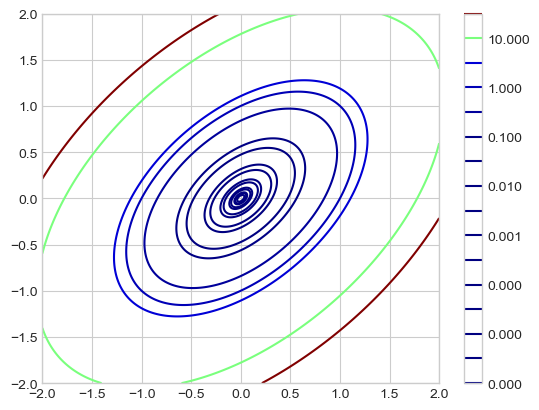

In [11]:
# Contour plot

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2, 0.1, 0.5,1,1.5,10,20]
cs = ax.contour(x1_grid,x2_grid,f_grid,levels=levels,cmap=cm.jet)
fig.colorbar(cs);

**Answer:** A1.py and A2.py

**Question B:** Construct python functions for the jacobian and the hessian.

In [12]:
f_python = lambda x: _f(x[0],x[1])

_f1 = sm.lambdify((x1, x2), f1)
_f2 = sm.lambdify((x1, x2), f2)

# write your code here
def jacob(x):
    jacob_matrix = np.array([_f1(x[0], x[1]), _f2(x[0], x[1])])
    return jacob_matrix

In [13]:
x = np.array([1,1])
jacob(x)

array([2, 2])

In [14]:
_f11 = sm.lambdify((x1, x2), f11)
_f12 = sm.lambdify((x1, x2), f12)
_f21 = sm.lambdify((x1, x2), f21)
_f22 = sm.lambdify((x1, x2), f22)

# write your code here
def hessian(x):
    h_matrix = np.array([[_f11(x[0], x[1]),_f12(x[0], x[1]) ], [_f21(x[0], x[1]), _f22(x[0], x[1]) ]])
    return h_matrix

In [15]:
hessian(x)

array([[6, 0],
       [0, 6]])

**Answer:** A3.py

**Question C:** Minimize $f(x_1,x_2)$ using respectively

1. Nelder-Mead,
2. BFGS without analytical jacobian,
3. BFGS with analytical jacobian, and
4. Newton-CG with analytical jacobian and hessian

Compare the results and discuss which optimizer you prefer.

**Optional:** If you wish, you can use the functions defined in the hidden cells below to also track how the optimizers converges to the solution.

In [16]:
def collect(x):
    
    # globals used to keep track across iterations
    global evals # set evals = 0 before calling optimizer
    global x0
    global x1s
    global x2s
    global fs
    
    # a. initialize list
    if evals == 0:
        x1s = [x0[0]] 
        x2s = [x0[1]]
        fs = [f_python(x0)]
        
    # b. append trial values
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(f_python(x))
    
    # c. increment number of evaluations
    evals += 1

In [17]:
def contour():
    
    global evals
    global x1s
    global x2s
    global fs
    
    # a. contour plot
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    levels = np.sort([j*10**(-i) for i in [-1,0,1,2,3,4] for j in [0.5,1,1.5]])
    cs = ax.contour(x1_grid,x2_grid,f_grid,levels=levels,cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s,x2s,'-o',ms=4,color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    # b. function value
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(evals+1),fs,'-o',ms=4,color='black')
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 83


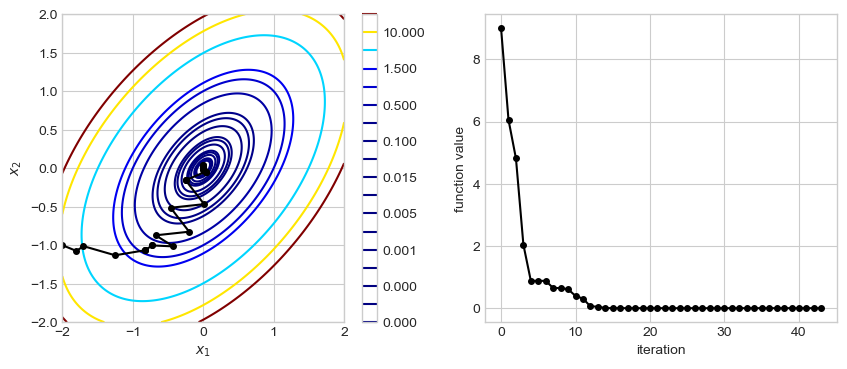

In [18]:
evals = 0
x0 = [-2,-1] # suggested initial guess

# write your code here
result = optimize.minimize(f_python, x0, method = "Nelder-Mead", callback = collect, options = {"disp": True} )

contour()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28


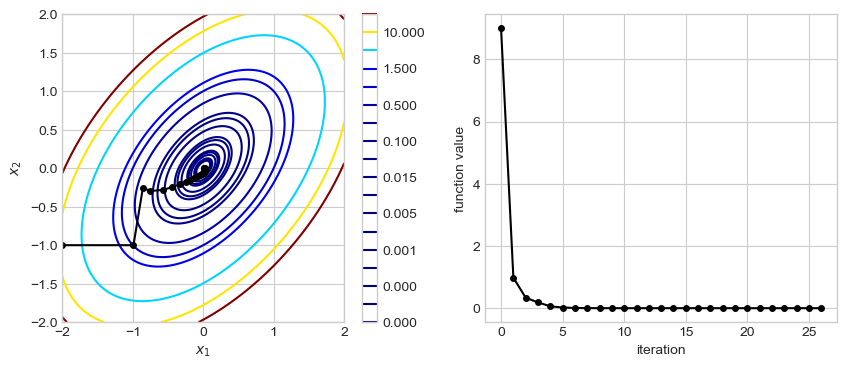

In [19]:
evals = 0
x0 = [-2,-1] # suggested initial guess

# write your code here
result = optimize.minimize(f_python, x0,jac = jacob, method = "BFGS", callback = collect, options = {"disp": True} )

contour()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 39
         Function evaluations: 123
         Gradient evaluations: 41


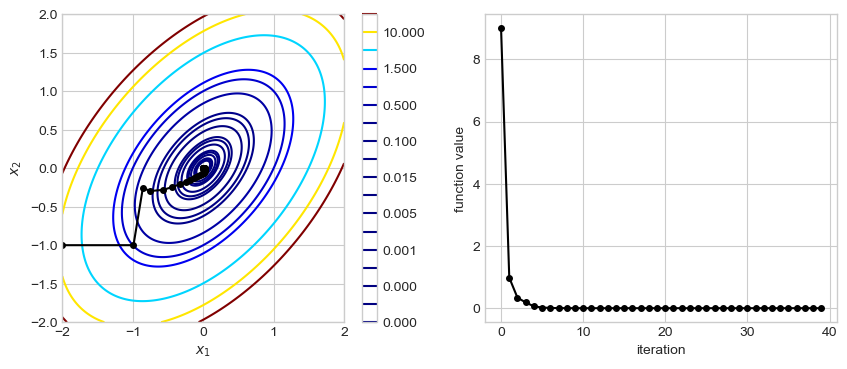

In [20]:
evals = 0
x0 = [-2,-1] # suggested initial guess

# write your code here
result = optimize.minimize(f_python, x0, method = "BFGS", callback = collect, options = {"disp": True}, tol = 1e-8 )

contour()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 15
         Gradient evaluations: 15
         Hessian evaluations: 15


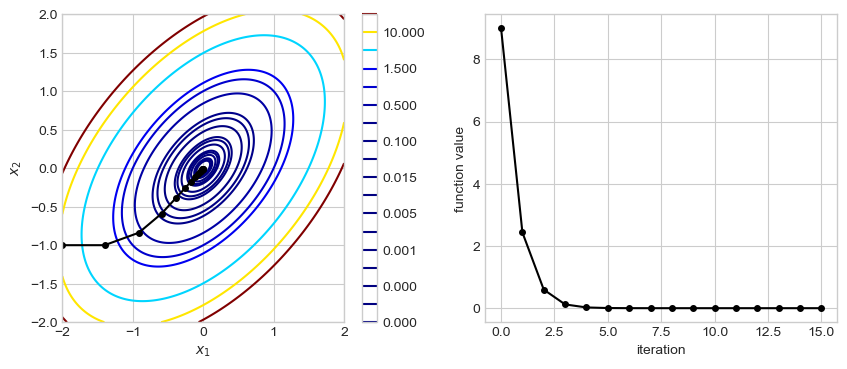

In [21]:
evals = 0
x0 = [-2,-1] # suggested initial guess

# write your code here
result = optimize.minimize(f_python, x0,jac = jacob, hess = hessian, method = "Newton-CG", callback = collect, options = {"disp": True} )

contour()

In [22]:
result.fun

2.158963057079746e-09

**Answer:** A4.py, A5.py, A6.py, A7.py

## Optimization problem II

Consider the function

$$
f(x_1,x_2) = (4-2.1x_1^2 + \frac{x_1^4}{3})x_1^2 + x_1x_2 + (4x_2^2 - 4)x_2^2)
$$

Define it in **sympy** by:

In [23]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (4-2.1*x1**2 + (x1**4)/3)*x1**2 + x1*x2 + (4*x2**2 - 4)*x2**2
_f = sm.lambdify((x1,x2),f)
f

x_1**2*(x_1**4/3 - 2.1*x_1**2 + 4) + x_1*x_2 + x_2**2*(4*x_2**2 - 4)

Create **3D plot**:

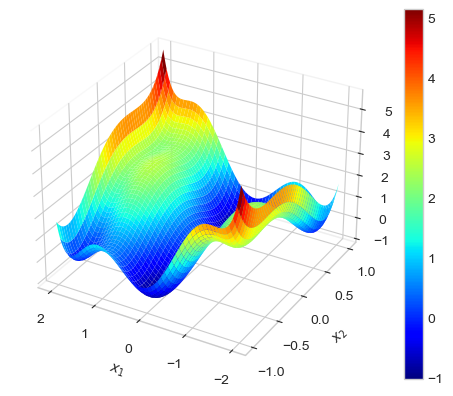

In [24]:
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-1,1,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
f_grid = _f(x1_grid,x2_grid)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,f_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# d. invert xaxis
ax.invert_xaxis()

# e. remove background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# f. add colorbar
fig.colorbar(cs);

**Question A:** Find the minimum of the function starting from each of the suggested initial values below. Print the first 20 solutions, and all solutions aftwards, which is the best yet to be found. Save the solutions and associated function values in `xs` and `fs`.

In [25]:
# a. python function for f
f_python = lambda x: _f(x[0],x[1])

# b. initial guesses
np.random.seed(1986)
K = 1000
x0s = np.empty((K,2))
x0s[:,0] = -2 + 4*np.random.uniform(size=K)
x0s[:,1] = -1 + 2*np.random.uniform(size=K)

# c. solutions and associated values
xs = np.empty((K,2))
fs = np.empty(K)

evals = 0
fopt = np.inf
xopt = np.nan
# write your code here
for i, x in enumerate(x0s):
    result = optimize.minimize(f_python, x0 = x, method = "BFGS")
    xs[i, :] = result.x
    f = result.fun
    fs[i] = f
    if i <= 10 or f < fopt:
        print(f'{i:4d}: x1 = {xs[i, 0]:.3f} and x2 = {xs[i, 1]:.3f} with f(x1, x2) = {fs[i]:.4f}')
        if f < fopt:
            fopt = f
            xopt = xs[i, :]
            i_solve = i
        


# best solution
print(f'\nbest solution:\n iteration {i_solve:4d}: x = ({xopt[0]:.2f},{xopt[1]:.2f}) -> f = {fopt:.4f}')



   0: x1 = 0.090 and x2 = -0.713 with f(x1, x2) = -1.0316
   1: x1 = -1.704 and x2 = 0.796 with f(x1, x2) = -0.2155
   2: x1 = 0.090 and x2 = -0.713 with f(x1, x2) = -1.0316
   3: x1 = 1.704 and x2 = -0.796 with f(x1, x2) = -0.2155
   4: x1 = 0.090 and x2 = -0.713 with f(x1, x2) = -1.0316
   5: x1 = -0.090 and x2 = 0.713 with f(x1, x2) = -1.0316
   6: x1 = -0.090 and x2 = 0.713 with f(x1, x2) = -1.0316
   7: x1 = 0.090 and x2 = -0.713 with f(x1, x2) = -1.0316
   8: x1 = -0.090 and x2 = 0.713 with f(x1, x2) = -1.0316
   9: x1 = -0.090 and x2 = 0.713 with f(x1, x2) = -1.0316
  10: x1 = -0.090 and x2 = 0.713 with f(x1, x2) = -1.0316
  13: x1 = 0.090 and x2 = -0.713 with f(x1, x2) = -1.0316
  24: x1 = 0.090 and x2 = -0.713 with f(x1, x2) = -1.0316
  27: x1 = 0.090 and x2 = -0.713 with f(x1, x2) = -1.0316
 155: x1 = 0.090 and x2 = -0.713 with f(x1, x2) = -1.0316

best solution:
 iteration  155: x = (0.09,-0.71) -> f = -1.0316


**Answer:** A8.py

**Question B:** Create a 3D scatter plot of where the optimizer converges, and color the dots by the associated function values.

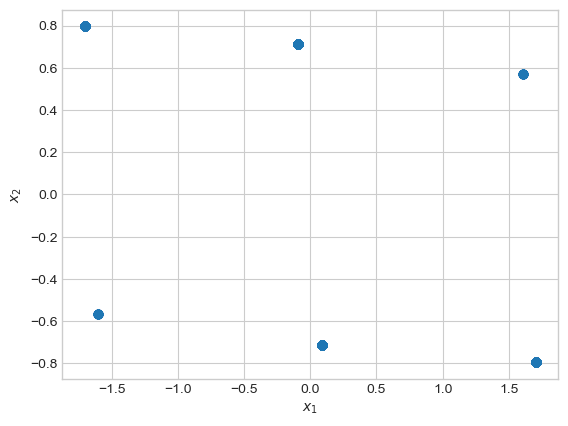

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

**Answer:** A9.py

**Question C:** Plot the function values at the solutions as a function of the starting values.

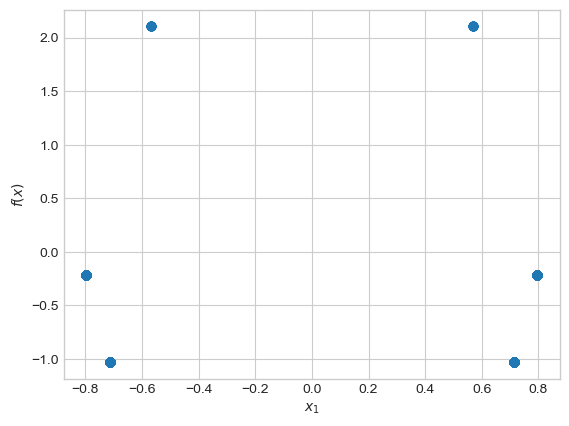

In [27]:
# write your code here
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:, 1],fs)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$f(x)$');

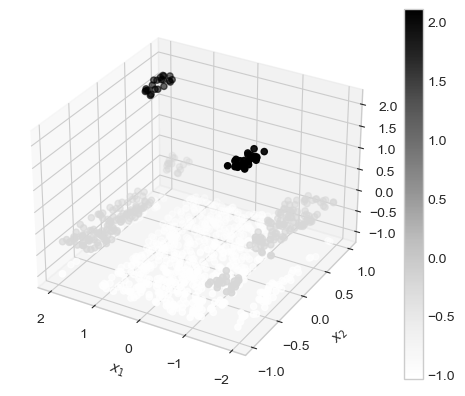

In [29]:
# a. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.scatter(x0s[:,0],x0s[:,1],fs,c=fs);        

# b. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# c. invert xaxis
ax.invert_xaxis()

# d. colorbar
fig.colorbar(cs);

**Answer:** A10.py

# Problem: Solve the consumer problem with income risk I

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is consumption in period $t$
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\nu > 0 $, $\kappa > 0$, $\xi > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
 \text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) & = 
\max_{c_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right] \\
\text{s.t.} \\
m_2 &= (1+r)(m_{1}-c_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

The **basic functions** are:

In [53]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def bequest(m,c,nu,kappa,rho):
    return nu*(m-c+kappa)**(1-rho)/(1-rho)

def v2(c2,m2,rho=rho,nu=nu,kappa=kappa):
    return utility(c2,rho) + bequest(m2,c2,nu,kappa,rho)

def v1(c1,m1,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1) + 1-Delta
    v2_low = v2_interp([m2_low])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1) + 1+Delta
    v2_high = v2_interp([m2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,rho) + beta*v2

The **solution functions** are:

In [49]:
def solve_period_2(rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,5,500)
    v2_vec = np.empty(500)
    c2_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

        # i. objective
        obj = lambda x: -v2(x[0],m2,rho,nu,kappa)

        # ii. initial value (consume half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m2),))

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x[0]
        
    return m2_vec,v2_vec,c2_vec

def solve_period_1(rho,beta,r,Delta,v1,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-8,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],m1,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess (consume half)
        x0 = m1/2
        
        # iii. optimize
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m1),))
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
     
    return m1_vec,v1_vec,c1_vec

**Question A:** Find optimal consumption in the first period as funcition of cash-on-hand, and plot it.

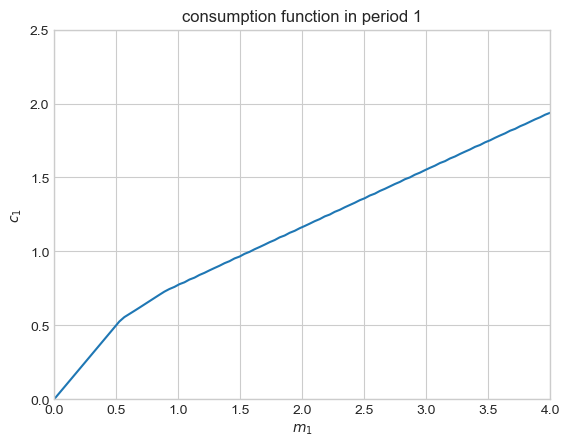

In [59]:
rho = 8
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

# b. solve

# solve period 2
m2_vec, v2_vec, c2_vec = solve_period_2(rho, nu, kappa, Delta)

v2_interp = interpolate.RegularGridInterpolator([m2_vec], v2_vec,
                                                bounds_error=False,
                                                fill_value=None)

m1_vec, v1_vec, c1_vec = solve_period_1(rho,beta,r,Delta,v1,v2_interp)

# c. plot
# c1 as a function of m1
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);

**Answer:** A11.py

**Question B:** Find optimal consumption in the first period as funcition of cash-on-hand, and plot it, assuming that

$$ 
y_{2} = \begin{cases}
1-\sqrt{\Delta} & \text{with prob. }0.1\\
1-\Delta & \text{with prob. }0.4\\
1+\Delta & \text{with prob. }0.4\\ 
1+\sqrt{\Delta} & \text{with prob. }0.1
\end{cases}
$$

which add some low probability tail events, but does not change mean income. Give an interpretation of the change in the consumption function.

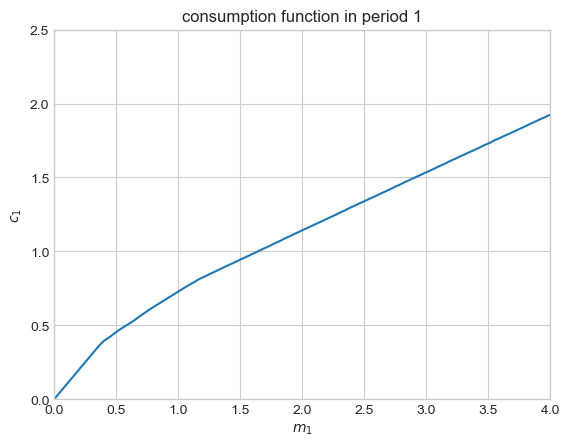

In [60]:
# write your code here
def v1(c1,m1,rho,beta,r,Delta,v2_interp):
    
    # a. v2 if income very low
    m2_vlow = (1+r)*(m1-c1) + 1-np.sqrt(Delta)
    v2_vlow = v2_interp([m2_vlow])[0]

    # b. v2 if income low
    m2_low = (1+r)*(m1-c1) + 1-Delta
    v2_low = v2_interp([m2_low])[0]

    # c. v2 if income very high
    m2_high = (1+r)*(m1-c1) + 1+np.sqrt(Delta)
    v2_high = v2_interp([m2_high])[0]

    # d. v2 if income very high
    m2_vhigh = (1+r)*(m1-c1) + 1+Delta
    v2_vhigh = v2_interp([m2_vhigh])[0]
    
    # c. expected v2 value
    v2 = 0.1*v2_vlow + 0.4*v2_low + 0.4*v2_high + 0.1*v2_vhigh
    
    # d. total value
    return utility(c1,rho) + beta*v2


rho = 8
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

# b. solve

# solve period 2
m2_vec, v2_vec, c2_vec = solve_period_2(rho, nu, kappa, Delta)

v2_interp = interpolate.RegularGridInterpolator([m2_vec], v2_vec,
                                                bounds_error=False,
                                                fill_value=None)

m1_vec, v1_vec, c1_vec = solve_period_1(rho,beta,r,Delta,v1,v2_interp)

# c. plot
# c1 as a function of m1
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);

There is now a higher chance of getting a low income in period two, so now for lower values of m1 do they start saving consumption, to smooth between periods.

**Answer:** A12.py

# Problem: Solve the consumer problem with income risk II

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is non-durable consumption in period $t$
* $d_t$ is durable consumption in period $t$ (only adjustable in period 1)
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\alpha \in (0,1)$, $\nu > 0 $, $\kappa > 0$, $\xi > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2},d_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\alpha\frac{d_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}+d_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
\text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) &= \max_{c_{1},d_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\alpha\frac{d_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2,d_2)\right]\\&\text{s.t.}&\\
m_2 &= (1+r)(m_{1}-c_{1}-d_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1}+d_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

Choose **parameters**:

In [34]:
rho = 2
alpha = 0.1
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

# b. solve
# write your code here

# c. plot
# write your code here

The **basic functions** are:

In [35]:
def utility(c,d,alpha,rho):
    return c**(1-rho)/(1-rho) + alpha*d**(1-rho)/(1-rho)

def bequest(m,c,d,nu,kappa,rho):
    return nu*(m+d-c+kappa)**(1-rho)/(1-rho)

def v2(c2,d2,m2,alpha,rho,nu,kappa):
    return utility(c2,d2,alpha,rho) + bequest(m2,c2,d2,nu,kappa,rho)

def v1(c1,d1,m1,alpha,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1-d1) + 1-Delta
    v2_low = v2_interp([m2_low,d1])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1-d1) + 1+Delta
    v2_high = v2_interp([m2_high,d1])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,d1,alpha,rho) + beta*v2

The **solution function for period 2** is:

In [36]:
def solve_period_2(alpha,rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,5,200)
    d2_vec = np.linspace(1e-6,5,100)
    v2_grid = np.empty((200,100))
    c2_grid = np.empty((200,100))

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):
        for j,d2 in enumerate(d2_vec):

            # i. objective
            obj = lambda x: -v2(x[0],d2,m2,alpha,rho,nu,kappa)

            # ii. initial value (consume half)
            x0 = m2/2

            # iii. optimizer
            result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m2),))

            # iv. save
            v2_grid[i,j] = -result.fun
            c2_grid[i,j] = result.x[0]
        
    return m2_vec,d2_vec,v2_grid,c2_grid

**Question A:** Solve for consumption in period 2 and plot the consumption function.

In [37]:
# write your code here

**Answer:** A13.py

**Question B:** Find optimal consumption and choices of durables in the first period as a function of cash-on-hand and plot it.

In [38]:
# write your code here

**Answer:** A14.py

# Extra Problems

**Simulate** a distribution of consumers in either of the two consumption-saving models above. See **section 6.3 in lecture 11** regarding 
how this is done.